### Retriever And Chain With Langchain

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

groq_api_key = os.getenv('GROQ_API_KEY')

if groq_api_key is not None:
	os.environ['GROQ_API_KEY'] = groq_api_key
else:
	raise ValueError("GROQ_API_KEY is not set in the environment variables.")

In [2]:
from langchain_community.document_loaders import PyPDFLoader
loader = PyPDFLoader('attention.pdf')
docs = loader.load()
docs

[Document(metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BLEU onEnglish-to-German translation, improving over the existing best ensemble result by over 1 BLEU. On 

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
text_splitter.split_documents(docs)[:5]  # Displaying only the first 5 chunks for brevity


[Document(metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BLEU onEnglish-to-German translation, improving over the existing best ensemble result by over 1 BLEU. On 

In [4]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

embedding = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

db = FAISS.from_documents(docs[:50], embedding)
db.save_local("faiss_index")

# small embedding model for testing

C:\Users\Admin\AppData\Local\Temp\ipykernel_17852\2261866619.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding = HuggingFaceEmbeddings(


In [5]:
query = "What is attention in deep learning?"
result = db.similarity_search(query, k=2)
result[0].page_content

'Attention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗†\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser ∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models are based on complex recurrent or\nconvolutional neural networks that include an encoder and a decoder. The best\nperforming models also connect the encoder and decoder through an attention\nmechanism. We propose a new simple network architecture, the Transformer,\nbased solely on attention mechanisms, dispensing with recurrence and convolutions\nentirely. Experiments on two machine translation tasks show these models to\nbe superior in quality while being more parallelizable and requiring signiﬁcantl

### prompt + chains + retriever

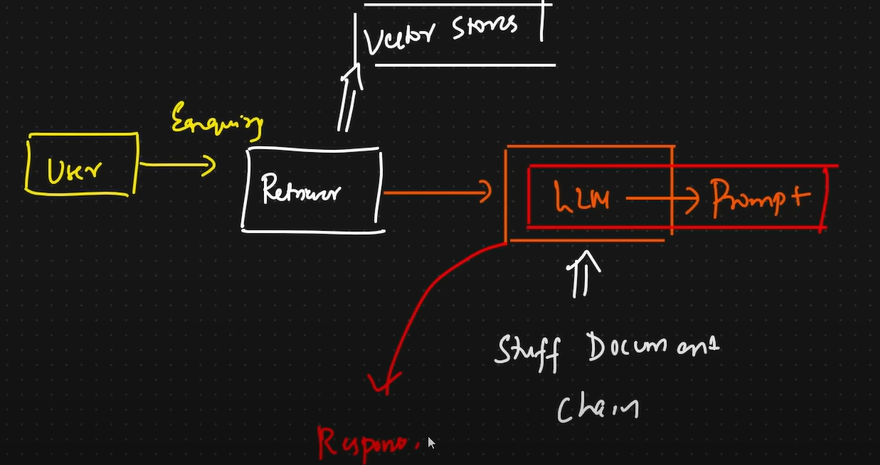

In [ ]:
# Local LLM
from langchain_community.llms import Ollama
llm = Ollama(model='phi:latest')
llm

C:\Users\Admin\AppData\Local\Temp\ipykernel_9504\2613835919.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model='phi:latest')


Ollama(model='phi:latest')

In [8]:
from langchain_core.prompts import ChatPromptTemplate
prompt =ChatPromptTemplate.from_template(
    """
    You are a helpful assistant. Use only the context provided below to answer the question.
If the context does not contain relevant information, say "I don't know based on the context."
    <context>
    {context}
    </context>
    Question : {input}
"""
)

In [9]:
'''
In LangChain, a retriever is an abstraction used to fetch relevant documents or text chunks based on a user query.
It works by converting the query into an embedding and performing vector similarity search over a vector store (like FAISS or Chroma) to return the most semantically relevant results.
Retrievers are a key component in Retrieval-Augmented Generation (RAG) pipelines, as they help supply context to the language model for more accurate and grounded responses.
'''

retriever=db.as_retriever()
retriever

VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000020BB979C750>, search_kwargs={})

In [19]:
## chain Introduction := list of documents -> format into prompt -> call LLM -> return answer
## create stuff document chain

from langchain.chains.combine_documents import create_stuff_documents_chain
document_chain = create_stuff_documents_chain(llm=llm, prompt=prompt)


In [20]:
# Retriever chain
'''
A retriever chain is a chain that first uses a retriever to fetch context documents based on a query,
and then uses a language model (LLM) to generate an answer using those documents as context.
'''

from langchain.chains import create_retrieval_chain
retrieval_chain = create_retrieval_chain(retriever, document_chain)


In [21]:
retrieval_chain.invoke({"input":"what is attention in deep learning?"})

{'input': 'what is attention in deep learning?',
 'context': [Document(id='6e44cbed-db9c-4de2-bf7e-ab1862c06114', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BL

In [6]:
# Groq LLM
from langchain_groq import ChatGroq
llm2 = ChatGroq(model="llama3-70b-8192")
llm2

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000020BBC334390>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000020BBC473410>, model_name='llama3-70b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [10]:
from langchain.chains.combine_documents import create_stuff_documents_chain
document_chain = create_stuff_documents_chain(llm2, prompt)

In [12]:
from langchain.chains import create_retrieval_chain
retrieval_chain = create_retrieval_chain(retriever, document_chain)

In [13]:
retrieval_chain.invoke({"input":"what is attention in deep learning?"})

{'input': 'what is attention in deep learning?',
 'context': [Document(id='68f65b45-6817-4151-88e5-e476275339a0', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BL

In [ ]:
retrieval_chain.invoke({"input": "What is a pokemon?"})
# yes it's working fine

{'input': 'What is a pokemon?',
 'context': [Document(id='9a5eada7-d5da-425e-af4d-8a22c2dc3a8a', metadata={'producer': 'PyPDF2', 'creator': 'PyPDF', 'creationdate': '', 'subject': 'Neural Information Processing Systems http://nips.cc/', 'publisher': 'Curran Associates, Inc.', 'language': 'en-US', 'created': '2017', 'eventtype': 'Poster', 'description-abstract': 'The dominant sequence transduction models are based on complex recurrent orconvolutional neural networks in an encoder and decoder configuration. The best performing such models also connect the encoder and decoder through an attentionm echanisms.  We propose a novel, simple network architecture based solely onan attention mechanism, dispensing with recurrence and convolutions entirely.Experiments on two machine translation tasks show these models to be superiorin quality while being more parallelizable and requiring significantly less timeto train. Our single model with 165 million parameters, achieves 27.5 BLEU onEnglish-to-G

In [34]:
print(type(llm2))

<class 'langchain_groq.chat_models.ChatGroq'>
